## Implementación de métricas de evaluación de IR

In [3]:
from pathlib import Path

import numpy as np
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd

### Precision

Se define como la proporción de documentos recuperados (RET) que son relevantes (REL).

$\mathcal{P} = \frac{|\text{RET} \: \cap \: \text{REL}|}{|\text{RET}|}$

In [4]:
def precision(relevance_query: List[int]):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."

    return sum(relevance_query) / len(relevance_query)

In [5]:
precision([0, 0, 0, 1])

0.25

### Precision at K

Se define como la proporción de documentos top-K recuperados que son relevantes.

In [6]:
def precision_at_k(relevance_query: List[int], k: int):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."
    assert k > 0, "K must be greater or equal than 1."

    return sum(relevance_query[:k]) / len(relevance_query[:k])

In [7]:
precision_at_k([0, 0, 0, 1], 1)

0.0

### Recall at K

Se define como la proporción de documentos relevantes que se recuperan en el top K.

In [8]:
def recall_at_k(relevance_query: List[int], k: int, num_relevant_docs: int):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."
    assert k > 0, "K must be greater or equal than 1."
    assert num_relevant_docs > 0, "Number of relevant docs must be greater or equal than 1."

    return sum(relevance_query[:k]) / num_relevant_docs

In [9]:
recall_at_k([0, 0, 0, 1], 1, 4)

0.0

### Average precision

Se define como el promedio de los **Precision at K**, calculados de manera iterativa al aumentar iterativamente **K** cada vez que se encuentra un documento relevante. El cálculo se detiene cuando se obtiene un **recall** de 1.

In [10]:
def average_precision(relevance_query: List[int]):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."

    cumulative_precision = 0
    relevant_count = 0

    for observation_count, relevance in enumerate(relevance_query, 1):
        if relevance:
            relevant_count += 1
            cumulative_precision += relevant_count / observation_count

    return cumulative_precision / relevant_count

In [11]:
average_precision([0, 1, 0, 1, 1, 1, 1])

0.5961904761904762

### Mean Average Precision (MAP)

Promedio de calcular el **Average Precision** para varias consultas.

In [12]:
def mean_average_precision(relevance_queries: List[List[int]]):
    assert all(set(sublist).issubset((0, 1)) for sublist in
               relevance_queries), "Only binary values (0, 1) allowed in all query results."

    return sum(average_precision(relevance_query) for relevance_query in relevance_queries) / len(relevance_queries)

In [13]:
mean_average_precision([[1, 0, 1], [0, 1, 1]])

0.7083333333333333

### Discounted Cumulative Gain at K

Sea $\text{REL}_i$ la relevancia asociada con el documento en el rango $i$, $1 \leq i \leq K$. Definimos:

$\text{DGG@K} = \sum_{i = 1}^{K} \frac{\text{REL}_i}{\log_2 (\max (i,\: 2))}$

In [14]:
def discounted_cumulative_gain(relevance_query: List[int], k: int):
    assert all(x >= 0 for x in relevance_query), "All elements must be integers greater than or equal to 0."
    assert k > 0, "K must be greater or equal than 1."

    return sum(relevance / np.log2(max(i, 2)) for i, relevance in enumerate(relevance_query[:k], 1))

In [15]:
discounted_cumulative_gain([4, 4, 3, 0, 0, 1, 3, 3, 3, 0], 6)

10.279642067948915

### Normalized Discounted Cumulative Gain at K

Dada la DGG@K de una consulta, se divide entre el mejor DGG@K posible para esa consulta.

In [16]:
def normalized_discounted_cumulative_gain(relevance_query: List[int], k: int):
    assert all(x >= 0 for x in relevance_query), "All elements must be integers greater than or equal to 0."
    assert k > 0, "K must be greater or equal than 1."

    rq = relevance_query.copy()
    rq.sort(reverse=True)
    return discounted_cumulative_gain(relevance_query, k) / discounted_cumulative_gain(rq, k)

In [17]:
normalized_discounted_cumulative_gain([4, 4, 3, 0, 0, 1, 3, 3, 3, 0], 6)

0.7424602308163405

## Query evaluation



In [18]:
def read_query_search_file(result_path: Path):
    results = {}
    with open(result_path, "r") as f_expert:
        for line in f_expert:
            query_name, query_results_text = line.split('\t')
            query_results = {}
            for result_text in query_results_text.split(','):
                doc_name, relevance = result_text.split(':')
                relevance = float(relevance)
                query_results[doc_name] = relevance
            results[query_name] = query_results
    return results


def plot_distribution(values: List[float], variable_name: str):
    sns.histplot(values, bins=30, kde=True)
    plt.title(f'Distribution of {variable_name}')
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.show()

def query_evaluation_metrics(expert_result_path: Path, model_result_path: Path):
    expert_results = read_query_search_file(expert_result_path)
    model_results = read_query_search_file(model_result_path)
    ms = []
    P_m = []
    R_m = []
    nDCG_m = []
    binary_queries = []
    for query in model_results:
        if query in expert_results:
            query_expert_relevant_documents = expert_results[query]
            query_model_relevant_documents = model_results[query]
            m = len(query_expert_relevant_documents)
            binary_relevance_query = [int(doc in query_expert_relevant_documents) for doc in query_model_relevant_documents]
            gain_relevance_query = [query_expert_relevant_documents.get(doc, 0) for doc in query_model_relevant_documents]
            ms.append(m)
            P_m.append(precision_at_k(binary_relevance_query, m))
            R_m.append(recall_at_k(binary_relevance_query, m, len(query_expert_relevant_documents)))
            nDCG_m.append(normalized_discounted_cumulative_gain(gain_relevance_query, m))
            binary_queries.append(binary_relevance_query)
    print(mean_average_precision(binary_queries))
    plot_distribution(ms, 'm')
    plot_distribution(P_m, 'P_m')
    plot_distribution(R_m, 'R_m')
    plot_distribution(nDCG_m, 'nDCG_m')
    
    


In [19]:
%run ranked_recovery.ipynb
%run inverted_index.ipynb

[nltk_data] Downloading package punkt to /home/gustavo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/gustavo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0.9576222428365284


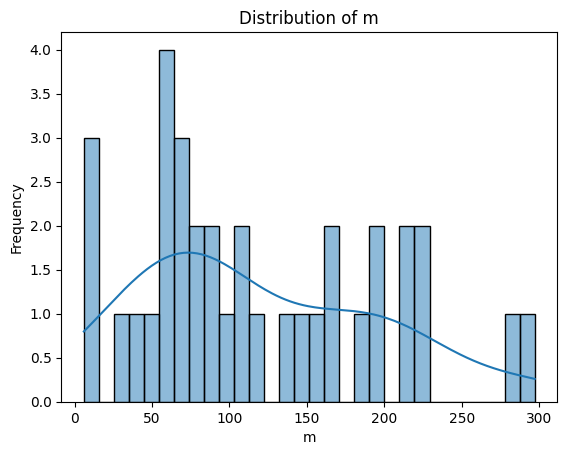

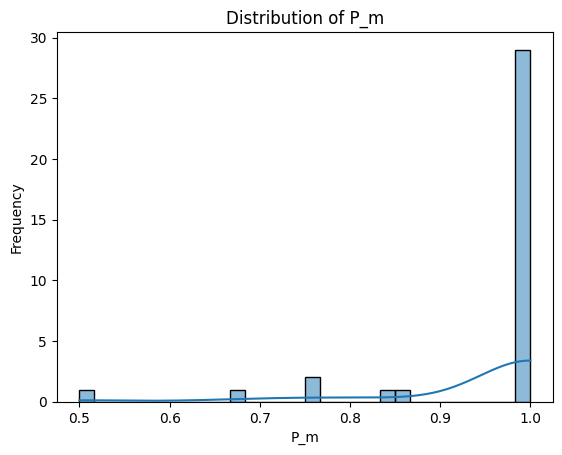

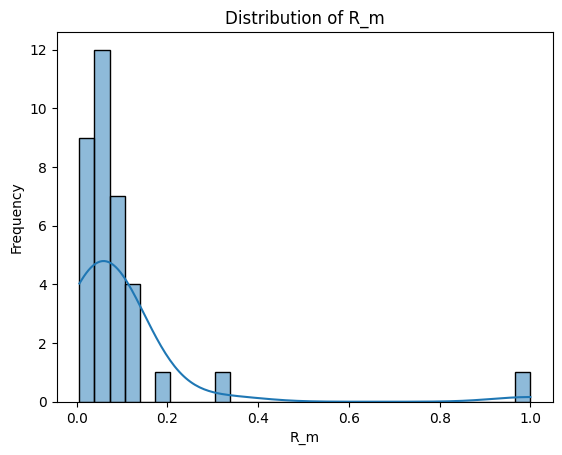

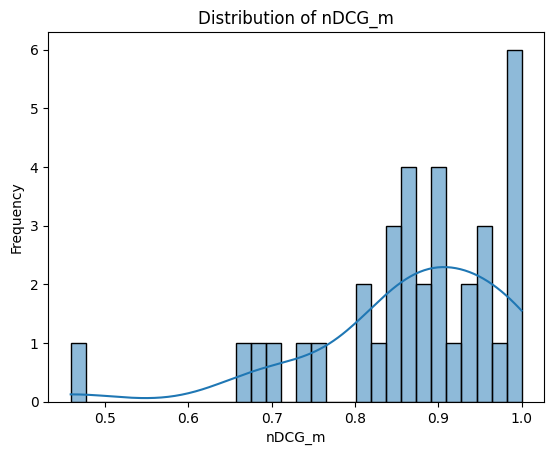

In [21]:
expert_results_path = 'data/relevance-judgments.tsv'
rrdv_results_path = 'data/RRDV-consultas_resultado'
query_evaluation_metrics(rrdv_results_path, expert_results_path)